In [1]:
from env import ImgRouterEvalEnv
from lightning_lite.utilities.seed import seed_everything
from bandit_algo import BanditAlgorithm
from preference_estimator import (
    EmpiricalEstimator,
    NeuralEstimator,
    RecurrentNeuralEstimator,
    RecurrentNeuralEstimatorV0,
    DummyEstimator,
)
from exploration_strategy import (
    PerArmExploration,
    UniformEpsilonExploration,
    RandomRouting,
)
import numpy as np

import matplotlib.pyplot as plt
import torch
plt.style.use("fivethirtyeight")
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"


In [2]:
num_tasks = 3
num_cls = 10
reduce_fator = 2
num_candidates = 256
# num_candidates = 512
num_slates = num_candidates // reduce_fator
use_img = True

max_steps = 200
num_seeds = 1

estimator_cfg = {
        "reset_period": 10,
    }

# explore_cfg = {
#     "epsilon": 2.0,
#     "min_epsilon": 0.01,
#     "decay_factor": 0.9,
# }

explore_cfg = {
    "epsilon": 2.0,
    "min_epsilon": 0.01,
    "decay_factor": 0.9,
}

cfg = {
        "num_candidates": num_candidates,
        "max_steps": max_steps,
        # "evaluate_strategy": "leave_one_out",
        # "evaluate_strategy": "each_one",
        "evaluate_strategy": "uniform",
        "use_img": use_img,
    }

In [3]:
def main(algo, env):
    obs = env.reset()
    # print("initial obs:", obs)
    done = False
    step_rewards = []
    pred_losses = []
    model_perfs = [env.model.test_acc()]
    while not done:
        action = algo.predict(obs)
        next_obs, reward, done, info = env.step(action)
        algo.update_estimator(obs, action, info["rewards"])
        obs = next_obs
        step_rewards.append(reward)
        # pred_loss = (algo.estimator.Q - env.Q) ** 2
        # pred_losses.append(pred_loss)
        model_perfs.append(env.model.test_acc())

    print("current samples after training:")
    print(env.current_samples)
    # routed_data = env.current_samples - existing_samples
    # routed_data = env.current_samples
    # print("routed data:")
    # print(routed_data)
    print("reward:", np.mean(step_rewards))
    return step_rewards, model_perfs


In [4]:
def get_algos():
    estimators = [EmpiricalEstimator(num_tasks, num_cls,cfg=estimator_cfg), 
                    NeuralEstimator(num_tasks, num_cls, use_img=use_img, cfg=estimator_cfg), 
                    RecurrentNeuralEstimatorV0(num_tasks, num_cls, use_img=use_img, cfg=estimator_cfg)]
    algos = [BanditAlgorithm(
            estimator,
             UniformEpsilonExploration(num_tasks, num_cls, num_slates, cfg=explore_cfg),
        ) for estimator in estimators]
    
    algos += [BanditAlgorithm(
        DummyEstimator(num_tasks, num_cls),
        RandomRouting(num_tasks, num_cls, num_slates))]
    
    return algos

In [5]:


torch.use_deterministic_algorithms(True)
estimator_step_rewards = {}
estimator_model_perfs = {}
algos = get_algos()


# TODO: BUG: get_algos would NOT work for different seeds
# since the estimator and explore are already initialized
# for estimator_cls in estimators:
for algo in algos:
    if use_img and algo.estimator.__class__ == EmpiricalEstimator:
        continue
    step_rewards, model_perfs = [], []
    for seed in range(num_seeds):
        seed_everything(seed)
        env = ImgRouterEvalEnv(cfg)
        # skip EmpiricalEstimator
        print("estimator:", algo.estimator.__class__.__name__)
        
        step_rewards_seed, model_perfs_seed = main(algo,env)
        step_rewards.append(step_rewards_seed)
        model_perfs.append(model_perfs_seed)
    
    estimator_step_rewards[algo.estimator.__class__.__name__] = np.array(step_rewards)
    estimator_model_perfs[algo.estimator.__class__.__name__] = np.array(model_perfs)

Global seed set to 0


Neural Estimator num params:  17605
Recurrent Estimator (one-feed) Num params 72037
estimator: NeuralEstimator
MNIST num parameters: 15298
step 0 epsilon 2.0
routed_batch_z (tensor([0, 1, 2]), tensor([82, 75, 99]))
step 1 epsilon 1.8
routed_batch_z (tensor([0, 1, 2]), tensor([81, 76, 99]))
step 2 epsilon 1.62
routed_batch_z (tensor([0, 1, 2]), tensor([87, 87, 82]))
step 3 epsilon 1.4580000000000002
routed_batch_z (tensor([0, 1, 2]), tensor([81, 89, 86]))
step 4 epsilon 1.3122000000000003
routed_batch_z (tensor([0, 1, 2]), tensor([81, 87, 88]))
step 5 epsilon 1.1809800000000004
routed_batch_z (tensor([0, 1, 2]), tensor([92, 85, 79]))
step 6 epsilon 1.0628820000000003
routed_batch_z (tensor([0, 1, 2]), tensor([88, 88, 80]))
step 7 epsilon 0.9565938000000003
routed_batch_z (tensor([0, 1, 2]), tensor([88, 89, 79]))
step 8 epsilon 0.8609344200000003
routed_batch_z (tensor([0, 1, 2]), tensor([ 74, 100,  82]))
step 9 epsilon 0.7748409780000003
routed_batch_z (tensor([0, 1, 2]), tensor([82, 86

Global seed set to 0


current samples after training:
[[1408. 1621. 1409. 1419. 1377. 1248. 1333. 1475. 1418. 1406.]
 [ 873.  856.  853.  851.  921. 1010.  854.  950.  852.  944.]
 [ 818.  979.  934.  887.  892.  857. 1024.  946.  834.  879.]]
reward: 2.2253521096706392
estimator: RecurrentNeuralEstimatorV0
MNIST num parameters: 15298
step 0 epsilon 2.0
routed_batch_z (tensor([0, 1, 2]), tensor([82, 75, 99]))


>> RESET

step 1 epsilon 1.8
routed_batch_z (tensor([0, 1, 2]), tensor([81, 76, 99]))
step 2 epsilon 1.62
routed_batch_z (tensor([0, 1, 2]), tensor([87, 87, 82]))
step 3 epsilon 1.4580000000000002
routed_batch_z (tensor([0, 1, 2]), tensor([81, 89, 86]))
step 4 epsilon 1.3122000000000003
routed_batch_z (tensor([0, 1, 2]), tensor([81, 87, 88]))
step 5 epsilon 1.1809800000000004
routed_batch_z (tensor([0, 1, 2]), tensor([92, 85, 79]))
step 6 epsilon 1.0628820000000003
routed_batch_z (tensor([0, 1, 2]), tensor([88, 88, 80]))
step 7 epsilon 0.9565938000000003
routed_batch_z (tensor([0, 1, 2]), tensor([88, 89, 79]))
step 8 epsilon 0.8609344200000003
routed_batch_z (tensor([0, 1, 2]), tensor([ 74, 100,  82]))
step 9 epsilon 0.7748409780000003
routed_batch_z (tensor([0, 1, 2]), tensor([82, 86, 88]))
step 10 epsilon 0.6973568802000003
routed_batch_z (tensor([0, 1, 2]), tensor([89, 93, 74]))


>> RESET

step 11 epsilon 0.6276211921800003
routed_batch_z (tensor([0, 1, 2]), tensor([82, 90, 84]))
step 12 epsilon 0.5648590729620003
routed_batch_z (tensor([0, 1, 2]), tensor([96, 81, 79]))
step 13 epsilon 0.5083731656658003
routed_batch_z (tensor([0, 1, 2]), tensor([86, 74, 96]))
step 14 epsilon 0.45753584909922024
routed_batch_z (tensor([0, 1, 2]), tensor([76, 87, 93]))
step 15 epsilon 0.4117822641892982
routed_batch_z (tensor([0, 1, 2]), tensor([87, 84, 85]))
step 16 epsilon 0.3706040377703684
routed_batch_z (tensor([0, 1, 2]), tensor([91, 71, 94]))
step 17 epsilon 0.33354363399333153
routed_batch_z (tensor([0, 1, 2]), tensor([80, 86, 90]))
step 18 epsilon 0.3001892705939984
routed_batch_z (tensor([0, 1, 2]), tensor([92, 76, 88]))
step 19 epsilon 0.27017034353459857
routed_batch_z (tensor([0, 1, 2]), tensor([97, 70, 89]))
step 20 epsilon 0.24315330918113873
routed_batch_z (tensor([0, 1, 2]), tensor([83, 81, 92]))


>> RESET

step 21 epsilon 0.21883797826302487
routed_batch_z (tensor([0, 1, 2]), tensor([84, 91, 81]))
step 22 epsilon 0.1969541804367224
routed_batch_z (tensor([0, 1, 2]), tensor([91, 85, 80]))
step 23 epsilon 0.17725876239305016
routed_batch_z (tensor([0, 1, 2]), tensor([83, 92, 81]))
step 24 epsilon 0.15953288615374514
routed_batch_z (tensor([0, 1, 2]), tensor([87, 73, 96]))
step 25 epsilon 0.14357959753837063
routed_batch_z (tensor([0, 1, 2]), tensor([92, 78, 86]))
step 26 epsilon 0.12922163778453358
routed_batch_z (tensor([0, 1, 2]), tensor([91, 74, 91]))
step 27 epsilon 0.11629947400608022
routed_batch_z (tensor([0, 1, 2]), tensor([89, 78, 89]))
step 28 epsilon 0.1046695266054722
routed_batch_z (tensor([0, 1, 2]), tensor([84, 78, 94]))
step 29 epsilon 0.09420257394492498
routed_batch_z (tensor([0, 1, 2]), tensor([78, 88, 90]))
step 30 epsilon 0.08478231655043249
routed_batch_z (tensor([0, 1, 2]), tensor([91, 94, 71]))


>> RESET

step 31 epsilon 0.07630408489538924
routed_batch_z (tensor([0, 1, 2]), tensor([ 83,  72, 101]))
step 32 epsilon 0.06867367640585031
routed_batch_z (tensor([0, 1, 2]), tensor([87, 89, 80]))
step 33 epsilon 0.061806308765265286
routed_batch_z (tensor([0, 1, 2]), tensor([82, 87, 87]))
step 34 epsilon 0.05562567788873876
routed_batch_z (tensor([0, 1, 2]), tensor([91, 86, 79]))
step 35 epsilon 0.05006311009986489
routed_batch_z (tensor([0, 1, 2]), tensor([89, 85, 82]))
step 36 epsilon 0.0450567990898784
routed_batch_z (tensor([0, 1, 2]), tensor([88, 76, 92]))
step 37 epsilon 0.040551119180890556
routed_batch_z (tensor([0, 1, 2]), tensor([86, 86, 84]))
step 38 epsilon 0.0364960072628015
routed_batch_z (tensor([0, 1, 2]), tensor([84, 85, 87]))
step 39 epsilon 0.03284640653652135
routed_batch_z (tensor([0, 1, 2]), tensor([ 90, 100,  66]))
step 40 epsilon 0.029561765882869215
routed_batch_z (tensor([0, 1, 2]), tensor([79, 90, 87]))


>> RESET

step 41 epsilon 0.026605589294582295
routed_batch_z (tensor([0, 1, 2]), tensor([87, 82, 87]))
step 42 epsilon 0.023945030365124065
routed_batch_z (tensor([0, 1, 2]), tensor([70, 94, 92]))
step 43 epsilon 0.02155052732861166
routed_batch_z (tensor([0, 1, 2]), tensor([82, 91, 83]))
step 44 epsilon 0.019395474595750493
routed_batch_z (tensor([0, 1, 2]), tensor([84, 86, 86]))
step 45 epsilon 0.017455927136175445
routed_batch_z (tensor([0, 1, 2]), tensor([66, 95, 95]))
step 46 epsilon 0.0157103344225579
routed_batch_z (tensor([0, 1, 2]), tensor([79, 86, 91]))
step 47 epsilon 0.01413930098030211
routed_batch_z (tensor([0, 1, 2]), tensor([79, 93, 84]))
step 48 epsilon 0.0127253708822719
routed_batch_z (tensor([0, 1, 2]), tensor([88, 83, 85]))
step 49 epsilon 0.01145283379404471
routed_batch_z (tensor([0, 1, 2]), tensor([91, 95, 70]))
step 50 epsilon 0.01030755041464024
routed_batch_z (tensor([0, 1, 2]), tensor([87, 70, 99]))


>> RESET

step 51 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([54, 42, 32]))
step 52 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([43, 42, 43]))
step 53 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([47, 40, 41]))
step 54 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([49, 42, 37]))
step 55 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([42, 43, 43]))
step 56 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([47, 35, 46]))
step 57 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([63, 22, 43]))
step 58 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([57, 33, 38]))
step 59 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([50, 36, 42]))
step 60 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([54, 36, 38]))


>> RESET

step 61 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 37, 40]))
step 62 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([63, 40, 25]))
step 63 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([50, 42, 36]))
step 64 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([54, 32, 42]))
step 65 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([59, 31, 38]))
step 66 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 38, 35]))
step 67 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([46, 42, 40]))
step 68 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 37, 36]))
step 69 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([57, 36, 35]))
step 70 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([58, 33, 37]))


>> RESET

step 71 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 39, 38]))
step 72 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([58, 37, 33]))
step 73 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([64, 28, 36]))
step 74 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([71, 19, 38]))
step 75 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([57, 36, 35]))
step 76 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([60, 35, 33]))
step 77 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([54, 39, 35]))
step 78 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([57, 37, 34]))
step 79 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([75, 22, 31]))
step 80 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([67, 28, 33]))


>> RESET

step 81 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([61, 38, 29]))
step 82 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([64, 32, 32]))
step 83 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([71, 24, 33]))
step 84 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 41, 32]))
step 85 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([71, 26, 31]))
step 86 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([62, 41, 25]))
step 87 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([79, 27, 22]))
step 88 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([69, 28, 31]))
step 89 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([61, 37, 30]))
step 90 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([59, 37, 32]))


>> RESET

step 91 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([68, 29, 31]))
step 92 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([65, 33, 30]))
step 93 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([56, 40, 32]))
step 94 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([57, 35, 36]))
step 95 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([69, 29, 30]))
step 96 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([69, 33, 26]))
step 97 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([56, 43, 29]))
step 98 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([66, 29, 33]))
step 99 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([66, 32, 30]))
step 100 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([63, 32, 33]))


>> RESET

step 101 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([66, 30, 32]))
step 102 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([64, 27, 37]))
step 103 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([67, 30, 31]))
step 104 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([73, 24, 31]))
step 105 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([71, 29, 28]))
step 106 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([54, 35, 39]))
step 107 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([56, 28, 44]))
step 108 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([73, 23, 32]))
step 109 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([48, 48, 32]))
step 110 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([63, 28, 37]))


>> RESET

step 111 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([71, 23, 34]))
step 112 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([59, 30, 39]))
step 113 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([63, 26, 39]))
step 114 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([53, 33, 42]))
step 115 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 32, 41]))
step 116 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([58, 41, 29]))
step 117 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([62, 33, 33]))
step 118 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([65, 32, 31]))
step 119 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([57, 35, 36]))
step 120 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([84, 26, 18]))


>> RESET

step 121 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([61, 26, 41]))
step 122 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([52, 42, 34]))
step 123 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([59, 26, 43]))
step 124 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([50, 40, 38]))
step 125 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 41, 36]))
step 126 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([63, 33, 32]))
step 127 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([62, 38, 28]))
step 128 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([47, 37, 44]))
step 129 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([59, 41, 28]))
step 130 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 29, 48]))


>> RESET

step 131 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([62, 40, 26]))
step 132 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([59, 42, 27]))
step 133 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([62, 31, 35]))
step 134 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([66, 29, 33]))
step 135 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([43, 38, 47]))
step 136 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([54, 37, 37]))
step 137 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([44, 39, 45]))
step 138 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([62, 32, 34]))
step 139 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([61, 31, 36]))
step 140 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([42, 38, 48]))


>> RESET

step 141 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 46, 31]))
step 142 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([50, 38, 40]))
step 143 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([59, 44, 25]))
step 144 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([57, 34, 37]))
step 145 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([43, 43, 42]))
step 146 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 32, 45]))
step 147 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([52, 38, 38]))
step 148 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([59, 37, 32]))
step 149 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([49, 43, 36]))
step 150 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([57, 34, 37]))


>> RESET

step 151 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([61, 35, 32]))
step 152 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([49, 44, 35]))
step 153 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([46, 45, 37]))
step 154 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([63, 38, 27]))
step 155 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([43, 39, 46]))
step 156 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 36, 37]))
step 157 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([52, 34, 42]))
step 158 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 45, 32]))
step 159 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([60, 32, 36]))
step 160 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([53, 42, 33]))


>> RESET

step 161 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([56, 35, 37]))
step 162 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([43, 49, 36]))
step 163 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([56, 38, 34]))
step 164 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([53, 37, 38]))
step 165 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([53, 40, 35]))
step 166 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([50, 36, 42]))
step 167 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 41, 36]))
step 168 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([48, 47, 33]))
step 169 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 38, 35]))
step 170 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([52, 41, 35]))


>> RESET

step 171 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([48, 41, 39]))
step 172 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([54, 34, 40]))
step 173 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([62, 33, 33]))
step 174 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([60, 37, 31]))
step 175 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 34, 43]))
step 176 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([50, 35, 43]))
step 177 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([52, 30, 46]))
step 178 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([43, 40, 45]))
step 179 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([50, 38, 40]))
step 180 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([53, 37, 38]))


>> RESET

step 181 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([52, 33, 43]))
step 182 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([48, 33, 47]))
step 183 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([60, 36, 32]))
step 184 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([53, 35, 40]))
step 185 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([43, 52, 33]))
step 186 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 48, 29]))
step 187 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([48, 45, 35]))
step 188 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([47, 39, 42]))
step 189 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([42, 41, 45]))
step 190 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 36, 37]))


>> RESET

step 191 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([60, 37, 31]))
step 192 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([56, 41, 31]))
step 193 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([54, 40, 34]))
step 194 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([48, 34, 46]))
step 195 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([51, 45, 32]))
step 196 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 33, 40]))
step 197 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([55, 29, 44]))
step 198 epsilon 0.01


Global seed set to 0


routed_batch_z (tensor([0, 1, 2]), tensor([60, 30, 38]))
step 199 epsilon 0.01
routed_batch_z (tensor([0, 1, 2]), tensor([47, 42, 39]))
current samples after training:
[[1265. 1278. 1274. 1482. 1215. 1205. 1213. 1302. 1245. 1271.]
 [ 919.  963. 1065.  915. 1091.  978.  911.  897.  940.  955.]
 [ 903. 1110. 1048.  902.  981.  906. 1131.  882.  939.  942.]]
reward: 2.145743112564087
estimator: DummyEstimator
MNIST num parameters: 15298
routed_batch_z (tensor([0, 1, 2]), tensor([35, 38, 55]))
routed_batch_z (tensor([0, 1, 2]), tensor([39, 41, 48]))
routed_batch_z (tensor([0, 1, 2]), tensor([44, 41, 43]))
routed_batch_z (tensor([0, 1, 2]), tensor([40, 42, 46]))
routed_batch_z (tensor([0, 1, 2]), tensor([46, 45, 37]))
routed_batch_z (tensor([0, 1, 2]), tensor([45, 52, 31]))
routed_batch_z (tensor([0, 1, 2]), tensor([45, 42, 41]))
routed_batch_z (tensor([0, 1, 2]), tensor([43, 43, 42]))
routed_batch_z (tensor([0, 1, 2]), tensor([36, 49, 43]))
routed_batch_z (tensor([0, 1, 2]), tensor([36, 46

NeuralEstimator 2.2253521096706392
RecurrentNeuralEstimatorV0 2.145743112564087
DummyEstimator 1.4430029368400574


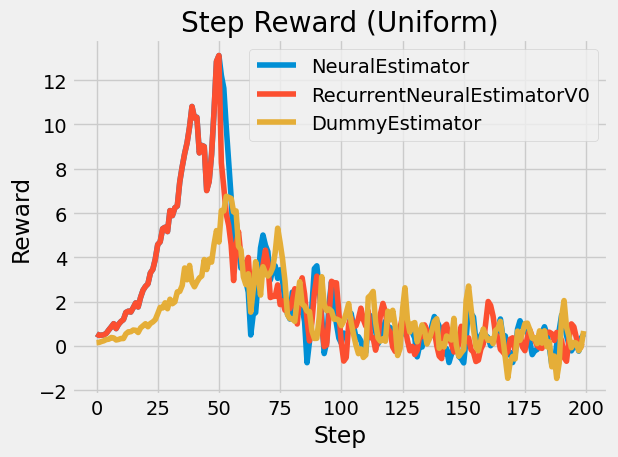

In [6]:
plt.title("Step Reward (Uniform)")
plt.ylabel("Reward")
plt.xlabel("Step")
for estimator_name, step_rewards in estimator_step_rewards.items():
    plt.plot(step_rewards.mean(axis=0), label=estimator_name)
    std = step_rewards.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        step_rewards.mean(axis=0) - std,
        step_rewards.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(step_rewards))
plt.legend(loc="best");
plt.tight_layout()

NeuralEstimator 0.626678590440372
RecurrentNeuralEstimatorV0 0.616455704627086
DummyEstimator 0.5726263551551163


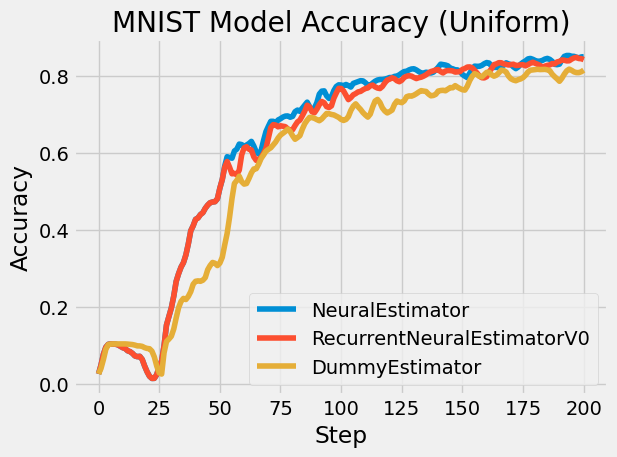

In [7]:
plt.title("MNIST Model Accuracy (Uniform)")
plt.ylabel("Accuracy")
plt.xlabel("Step")
for estimator_name, model_perfs in estimator_model_perfs.items():
    plt.plot(model_perfs.mean(axis=0), label=estimator_name)
    std = model_perfs.std(axis=0)
    plt.fill_between(
        np.arange(len(std)),
        model_perfs.mean(axis=0) - std,
        model_perfs.mean(axis=0) + std,
        alpha=0.2,
    )
    print(estimator_name, np.mean(model_perfs))
plt.legend(loc="best");
plt.tight_layout()